# AutoML Image Classification: 30m Challenge With Rotation (Digits)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/rotation.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    random_state = RandomState(42)
    x, y = load_digits(return_X_y=True)
    y = y.astype(np.uint8)
    return train_test_split(x, y, test_size=1/7, random_state=random_state)
    # (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # s = x_train.shape[1]
    # x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    # x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)    
    # return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    # err_img_node = Array(reshape=(28, 28))

    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node
    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(GaussianNoise("mean", "std"))
    # err_img_node.addfilter(Clip("min_val", "max_val"))
    # return err_root_node

In [5]:
def get_err_params_list(data):
    angle_steps = np.linspace(0, 180, num=6)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list
    # min_val = np.amin(data)
    # max_val = np.amax(data)
    # std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    # err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    # return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 30
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)

    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=20)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        # err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

30.31 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=9, min_samples_split=5, n_estimators=100), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.981

30.66 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=9, min_samples_split=5, n_estimators=100), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.981

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpivlqq8gc

  JVM stdout: /wrk/users/thalvari/tmpivlqq8gc/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpivlqq8gc/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#454013670
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_89d1 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.981

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmperwnr2si

  JVM stdout: /wrk/users/thalvari/tmperwnr2si/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmperwnr2si/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#23588354
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a277 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.984

 17%|█▋        | 1/6 [3:03:11<15:15:56, 10991.22s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.899

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.72

34.77 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(KNeighborsClassifier(RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.4, min_samples_leaf=10, min_samples_split=9, n_estimators=100), n_neighbors=22, p=2, weights=distance), n_neighbors=6, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.957

30.47 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=9, min_samples_split=5, n_estimators=100), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.786

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpzeuj4wct

  JVM stdout: /wrk/users/thalvari/tmpzeuj4wct/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpzeuj4wct/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#45406187
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aad6 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.942

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpna4x2j8t

  JVM stdout: /wrk/users/thalvari/tmpna4x2j8t/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpna4x2j8t/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,11 days
H2O cluster name:,#198550767
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8449 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.638

 33%|███▎      | 2/6 [6:10:52<12:18:08, 11072.16s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.883

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.44

36.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=9, max_features=0.4, min_samples_leaf=20, min_samples_split=17, n_estimators=100, subsample=1.0), n_neighbors=15, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.875

31.05 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=9, min_samples_split=5, n_estimators=100), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.518

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpugm5buck

  JVM stdout: /wrk/users/thalvari/tmpugm5buck/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpugm5buck/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#257549368
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b035 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.895

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpskp5four

  JVM stdout: /wrk/users/thalvari/tmpskp5four/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpskp5four/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#300672985
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aba8 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.412

 50%|█████     | 3/6 [9:20:18<9:18:01, 11160.38s/it] 

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.786

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.381

33.15 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.8500000000000001, min_samples_leaf=3, min_samples_split=18, n_estimators=100), n_neighbors=6, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.903

30.57 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=9, min_samples_split=5, n_estimators=100), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.412

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp9ej5kw7u

  JVM stdout: /wrk/users/thalvari/tmp9ej5kw7u/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp9ej5kw7u/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#962856057
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8e91 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.895

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpz5ndt1iw

  JVM stdout: /wrk/users/thalvari/tmpz5ndt1iw/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpz5ndt1iw/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#915972907
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a45f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.311

 67%|██████▋   | 4/6 [12:24:51<6:11:08, 11134.26s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.763

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.304

31.26 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(LogisticRegression(input_matrix, C=0.0001, dual=True, penalty=l2), degree=2, include_bias=False, interaction_only=False), C=20.0, dual=False, penalty=l2)

<class 'tpot.tpot.TPOTClassifier'>

0.833

30.38 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=9, min_samples_split=5, n_estimators=100), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.354

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpokwue9tq

  JVM stdout: /wrk/users/thalvari/tmpokwue9tq/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpokwue9tq/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#403809720
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a8db closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.844

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpcjyuohmi

  JVM stdout: /wrk/users/thalvari/tmpcjyuohmi/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpcjyuohmi/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#188713986
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ae7e closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.28

 83%|████████▎ | 5/6 [15:29:20<3:05:14, 11114.62s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.72

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.28

30.17 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(input_matrix, n_neighbors=2, p=1, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.782

30.61 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.45, min_samples_leaf=9, min_samples_split=5, n_estimators=100), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.37

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp9n3enw8i

  JVM stdout: /wrk/users/thalvari/tmp9n3enw8i/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp9n3enw8i/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#529154513
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ac13 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.829

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp42_ckuoy

  JVM stdout: /wrk/users/thalvari/tmp42_ckuoy/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp42_ckuoy/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,12 days
H2O cluster name:,#197654888
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_99ae closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.28

100%|██████████| 6/6 [18:31:29<00:00, 11058.87s/it]  

100%|██████████| 6/6 [18:31:29<00:00, 11114.90s/it]

'AutoKeras #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.194,0.001,1802.8
36,0.899,0.992,0.203,0.001,1812.63
72,0.883,0.989,0.232,0.001,1807.93
108,0.786,0.984,0.286,0.001,1816.02
144,0.763,0.971,0.237,0.001,1826.39
180,0.72,0.948,0.204,0.001,1815.51


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)"
36,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1),

'AutoKerasClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.194,0.001,1806.99
36,0.72,0.999,0.203,0.001,1805.67
72,0.44,0.999,0.232,0.001,1804.35
108,0.381,0.999,0.286,0.001,1815.48
144,0.304,0.999,0.237,0.001,1811.96
180,0.28,0.999,0.204,0.001,1810.04


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)",nan
36,"Conv2d(1, 64, kernel_size=(3, 3), st

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.194,0.001,1857.74
36,0.942,1,0.203,0.001,1854.58
72,0.895,1,0.232,0.001,1852.13
108,0.895,1,0.286,0.001,1749.95
144,0.844,1,0.237,0.001,1852.43
180,0.829,1,0.204,0.001,1754.31


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107,pipe_108,pipe_109,pipe_110,pipe_111,pipe_112,pipe_113,pipe_114,pipe_115,pipe_116,pipe_117,pipe_118,pipe_119,pipe_120,pipe_121,pipe_122,pipe_123,pipe_124,pipe_125,pipe_126,pipe_127,pipe_128,pipe_129,pipe_130,pipe_131,pipe_132,pipe_133,pipe_134,pipe_135,pipe_136,pipe_137,pipe_138,pipe_139,pipe_140,pipe_141,pipe_142,pipe_143,pipe_144
0,StackedEnsemble_BestOfFamily_AutoML_20191119_084146,DeepLearning_grid_1_AutoML_20191119_084146_model_9,GBM_grid_1_AutoML_20191119_084146_model_39,XGBoost_grid_1_AutoML_20191119_084146_model_13,DRF_1_AutoML_20191119_084146,XRT_1_AutoML_20191119_084146,GLM_grid_1_AutoML_20191119_084146_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
36,StackedEnsemble_AllModels_AutoML_20191119_114924,DeepLearning_grid_1_AutoML_20191119_114924_model_3,DeepLearning_grid_1_AutoML_20191119_114924_model_9,GBM_grid_1_AutoML_20191119_114924_model_31,GBM_grid_1_AutoML_20191119_114924_model_39,DeepLearning_grid_1_AutoML_20191119_114924_model_15,DeepLearning_grid_1_AutoML_20191119_114924_model_4,DeepLearning_grid_1_AutoML_20191119_114924_model_10,DeepLearning_grid_1_AutoML_20191119_114924_model_2,GBM_grid_1_AutoML_20191119_114924_model_20,GBM_grid_1_AutoML_20191119_114924_model_12,GBM_3_AutoML_20191119_114924,GBM_grid_1_AutoML_20191119_114924_model_48,GBM_grid_1_AutoML_20191119_114924_model_18,GBM_grid_1_AutoML_20191119_114924_model_46,GBM_grid_1_AutoML_20191119_114924_model_41,GBM_grid_1_AutoML_20191119_114924_model_15,GBM_4_AutoML_20191119_114924,GBM_grid_1_AutoML_20191119_114924_model_27,GBM_grid_1_AutoML_20191119_114924_model_55,GBM_grid_1_AutoML_20191119_114924_model_40,GBM_grid_1_AutoML_20191119_114924_model_47,GBM_grid_1_AutoML_20191119_114924_model_3,GBM_grid_1_AutoML_20191119_114924_model_35,GBM_grid_1_AutoML_20191119_114924_model_19,GBM_grid_1_AutoML_20191119_114924_model_57,GBM_grid_1_AutoML_20191119_114924_model_67,GBM_grid_1_AutoML_20191119_114924_model_45,GBM_grid_1_AutoML_20191119_114924_model_66,GBM_grid_1_AutoML_20191119_114924_model_43,GBM_5_AutoML_20191119_114924,GBM_grid_1_AutoML_20191119_114924_model_58,GBM_2_AutoML_20191119_114924,XGBoost_1_AutoML_20191119_114924,GBM_grid_1_AutoML_20191119_114924_model_26,DRF_1_AutoML_20191119_114924,GBM_grid_1_AutoML_20191119_114924_model_32,GBM_grid_1_AutoML_20191119_114924_model_56,DeepLearning_grid_1_AutoML_20191119_114924_model_8,GBM_grid_1_AutoML_20191119_114924_model_1,GBM_grid_1_AutoML_20191119_114924_model_59,XRT_1_AutoML_20191119_114924,GBM_1_AutoML_20191119_114924,GBM_grid_1_AutoML_20191119_114924_model_11,GBM_grid_1_AutoML_20191119_114924_model_17,GBM_grid_1_AutoML_20191119_114924_model_14,GBM_grid_1_Au

'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.194,0.001,1860.7
36,0.638,1,0.203,0.001,1867.38
72,0.412,1,0.232,0.001,1860.61
108,0.311,1,0.286,0.001,1864.89
144,0.28,1,0.237,0.001,1857.55
180,0.28,1,0.204,0.001,1898.85


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107,pipe_108,pipe_109,pipe_110,pipe_111,pipe_112,pipe_113,pipe_114,pipe_115,pipe_116,pipe_117,pipe_118,pipe_119,pipe_120,pipe_121,pipe_122,pipe_123,pipe_124,pipe_125,pipe_126,pipe_127,pipe_128,pipe_129,pipe_130,pipe_131,pipe_132,pipe_133,pipe_134,pipe_135,pipe_136,pipe_137,pipe_138,pipe_139,pipe_140,pipe_141,pipe_142,pipe_143,pipe_144,pipe_145,pipe_146,pipe_147,pipe_148,pipe_149,pipe_150,pipe_151,pipe_152,pipe_153,pipe_154,pipe_155,pipe_156,pipe_157,pipe_158,pipe_159,pipe_160,pipe_161,pipe_162,pipe_163,pipe_164,pipe_165,pipe_166,pipe_167,pipe_168,pipe_169,pipe_170,pipe_171,pipe_172,pipe_173,pipe_174,pipe_175,pipe_176,pipe_177,pipe_178,pipe_179,pipe_180,pipe_181,pipe_182,pipe_183,pipe_184,pipe_185,pipe_186,pipe_187,pipe_188,pipe_189,pipe_190,pipe_191
0,StackedEnsemble_BestOfFamily_AutoML_20191119_091244,DeepLearning_grid_1_AutoML_20191119_091244_model_2,GBM_grid_1_AutoML_20191119_091244_model_39,XGBoost_grid_1_AutoML_20191119_091244_model_13,DRF_1_AutoML_20191119_091244,XRT_1_AutoML_20191119_091244,GLM_grid_1_AutoML_20191119_091244_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
36,StackedEnsemble_BestOfFamily_AutoML_20191119_122018,DeepLearning_grid_1_AutoML_20191119_122018_model_10,GBM_grid_1_AutoML_20191119_122018_model_39,XGBoost_grid_1_AutoML_20191119_122018_model_13,DRF_1_AutoML_20191119_122018,XRT_1_AutoML_20191119_122018,GLM_grid_1_AutoML_20191119_122018_model_1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
72,StackedEnsemble_BestOfFamily_AutoML_20191119_152952,DeepLearning_grid_1_AutoML_20191119_152952_model_2,GBM_grid_1_AutoML_20191119_152952_model_39,XGBoost_grid_1_AutoML_20191119_152952_model_13,DRF_1_AutoML_20191119_152952,XRT_1_AutoML_20191119_152952,GLM_grid_1_AutoML_20191119_152952_model_1,nan,

'TPOTClassifier #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.194,0.001,1821.58
36,0.957,1,0.203,0.001,2091.13
72,0.875,1,0.232,0.001,2176.31
108,0.903,1,0.286,0.001,1991.02
144,0.833,1,0.237,0.001,1895.71
180,0.782,1,0.204,0.001,1811.36


max_angle,pipe_0,pipe_1,pipe_2
0,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
36,"StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=22, p=2, weights='distance'))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=6, p=2, weights='distance')"
72,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=1.0, loss='deviance', max_depth=9, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=20, min_samples_split=17, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=15, p=2, weights='distance')",nan
108,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features=0.8500000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=3, min_samples_split=18, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=6, p=2, weights='distance')",nan
144,"StackingEstimator(estimator=LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False))","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","LogisticRegression(C=20.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
180,"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=2, p=1, weights='distance')",nan,nan


'TPOTClassifierClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.194,0.001,1840.7
36,0.786,1,0.203,0.001,1829.27
72,0.518,1,0.232,0.001,1864.29
108,0.412,1,0.286,0.001,1835.53
144,0.354,1,0.237,0.001,1824.31
180,0.37,1,0.204,0.001,1838.3


max_angle,pipe_0,pipe_1,pipe_2
0,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
36,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
72,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
108,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
144,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
180,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=9, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"


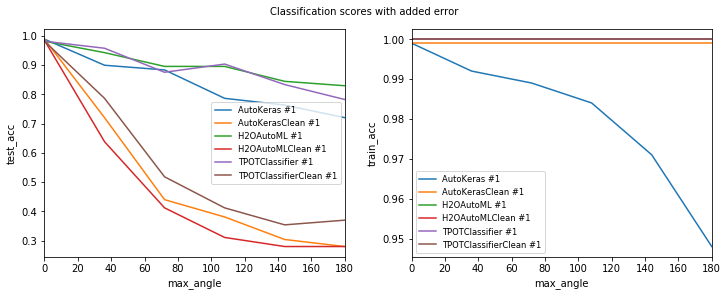

In [11]:
print_results_by_model(df,
    ["train_labels", "test_labels"],
    # ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    err_param_name="max_angle",
    # err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)